En este archivo se calcula
- La codificación predictiva lineal (LPC)

de un archivo de audio grabado por mí

Se explorarán tanto una implementación de biblioteca como una implementación propia.

In [2]:
import librosa
import librosa.display
import scipy.signal.windows as windows
from scipy.signal import lfilter
import soundfile as sf

import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
import math

In [3]:
# Análisis de la señal
# La señal se va a importar como una lista de magnitudes en el tiempo
# Además, el archivo tiene un sampling rate (ratio de muestreo)
original_signal, original_sampling_rate = librosa.load("audio.wav")

print("La señal tiene", len(original_signal), "muestras")
print("Y el ratio de muestreo es", original_sampling_rate, "Hz")
print("La señal tiene una duración de", len(original_signal)/original_sampling_rate, "s")

La señal tiene 261728 muestras
Y el ratio de muestreo es 22050 Hz
La señal tiene una duración de 11.869750566893424 s


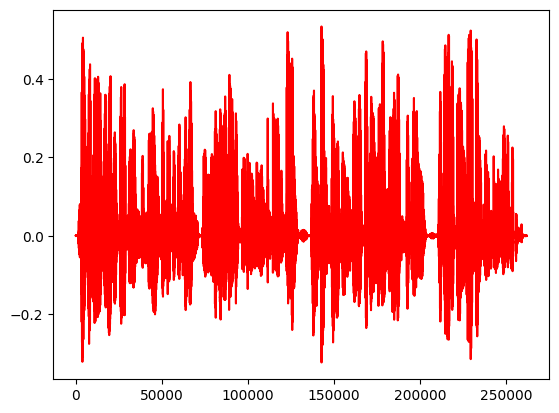

In [4]:
# Vamos a graficar la señal obtenida del archivo
plt.plot(np.array(range(0, len(original_signal))), original_signal, 'r')


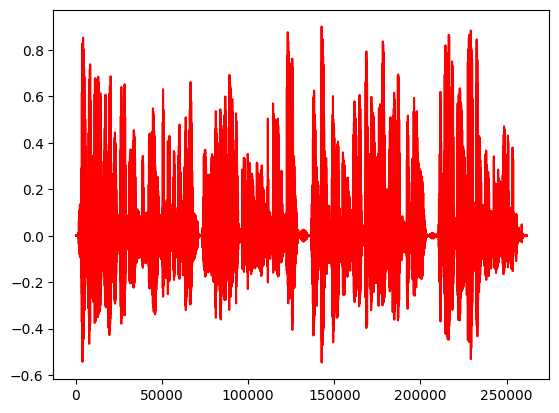

In [5]:
# En la gráfica podemos ver que la señal va (aprox) de -0.3 a 0.5, así que vamos a normalizarla para
#   trabajar en el espacio [-1, 1]

normalized_signal = 0.9*original_signal/max(abs(original_signal))

plt.plot(np.array(range(0, len(normalized_signal))), normalized_signal, 'r')


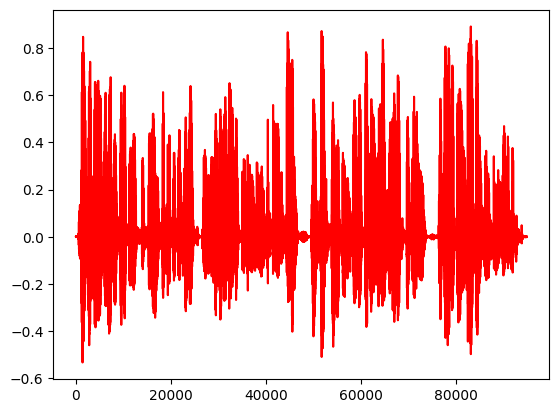

In [6]:
# Ahora, la señal original tiene un muestreo de 22050Hz, y es una señal de poco más de 10 segundos
#  así que para un procesamiento más rápido, se remuestreará la señal a 8kHz

sampling_rate = 8000

signal = librosa.resample(normalized_signal, orig_sr=original_sampling_rate, target_sr=sampling_rate)

plt.plot(np.array(range(0, len(signal))), signal, 'r')

(240,)


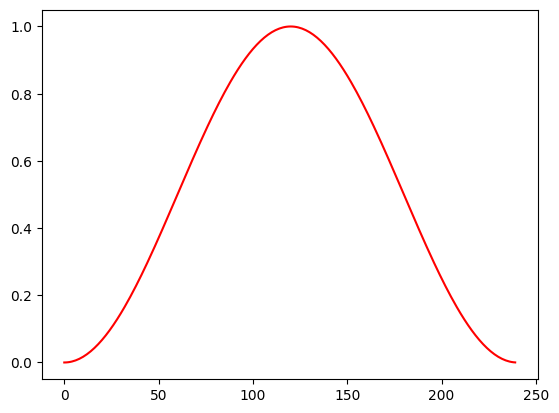

In [7]:
# Ahora bien, para poder calcular la lpc de la señal, primero haremos un ventaneo usando la ventana
#  de Hann

window_length = 0.03 # La duración de la ventana será de 3ms
window = windows.hann(math.floor(window_length * sampling_rate), False)
print(window.shape)

plt.plot(np.array(range(0, len(window))), window, 'r')

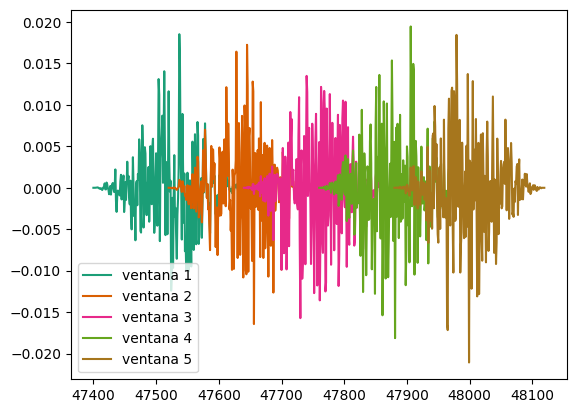

In [8]:
# Con esta ventana podemos ir haciendo bloques de la señal, con cierto nivel de traslape

def create_overlapping_blocks(signal, window, overlap_ratio = 0.5):
    signal_samples = len(signal)
    window_samples = len(window)
    step = math.floor(window_samples * (1 - overlap_ratio))
    number_of_blocks = (signal_samples - window_samples) // step + 1

    blocks = np.zeros((number_of_blocks, window_samples))

    for i in range(number_of_blocks):
        offset = i * step
        blocks[i, :] = window * signal[offset : window_samples + offset]
        
    return blocks

overlap_ratio = 0.5
blocks = create_overlapping_blocks(signal, window, overlap_ratio)

# Esto mostrará el resultado de 5 ventanas a la mitad del archivo

windows_samples = len(window)
window_time = np.array(range(windows_samples))
step = math.floor(windows_samples * (1 - overlap_ratio))

fig = plt.figure()
cmap = mpl.colormaps['Dark2']
ammount_to_plot = 5

for i in range(int(len(blocks)//2),int((len(blocks)//2) + ammount_to_plot)):
    offset = i * step
    color = cmap(((1/ammount_to_plot)*i)%1)
    plt.plot(window_time + offset, blocks[i], label=f"ventana {1+i-len(blocks)//2}", color=color)
    plt.legend()



La ecuación de la LPC es la siguiente:

$x_n = \sum^{p}_{k=1}a_kx_{n-k} + e_n$

donde

$x_n$ es muestra n de la señal

$a_k$ es el coeficiente de aproximación

y $e_n$ es el error

Es decir, necesitamos encontrar las $a_k$ que resuelvan el siguiente sistema:

$x_1 = e_1$

$x_2 = a_1x_1 + e_2$

$x_3 = a_1x_2 + a_2x_1 + e_3$

...

$x_{p+1} = a_1x_p + a_2x_{p-1} + ... + a_px_1 + e_{p+1}$

...

$x_n = a_1x_{n-1} + a_2x_{n-2} + ... + a_{p}x_{n-1} + e_n$

Si el error no existiera, tendríamos un sistema sobredeterminado (tiene muchas más ecuaciones que variables), pero tenemos que calcular tanto las variables ($a_i$), como los errores ($e_i$), así que vamos a asumir que no existen y aplicaremos una aproximación para ver cuáles $a_i$ resuleven mejor el sistema, y después calcularemos los errores

Para esto podemos reducir el problema a:

$\vec{x} = \textbf{X}\vec{a} + \vec{e}$

donde

$$\vec{x} =
\begin{bmatrix}
x_1\\
x_2\\
x_3\\
\vdots\\
x_n
\end{bmatrix}
$$

$$\vec{a} =
\begin{bmatrix}
a_1\\
a_2\\
\vdots\\
a_p
\end{bmatrix}
$$

$$\textbf{X} = 
\begin{bmatrix}
0 & 0 & \dots & 0 \\
x_1 & 0 & \dots & 0 \\
x_2 & x_1 & \dots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
x_{n-1} & x_{n-2} & \dots & x_{n-p} \\
\end{bmatrix}
$$

y
$$\vec{e} =
\begin{bmatrix}
e_1\\
e_2\\
e_3\\
\vdots\\
e_n
\end{bmatrix}
$$

Y la ecuación resultante se puede aproximar usando el error cuadrático mínimo (u otra métrica de error), pero en este caso se implementará usando el módulo de numpy para álgebra lineal

El número p (también llamado grado) es la cantidad de coeficientes que se van a aproximar. Este es el tamaño del vector de características que se va a utilizar

[ 0.62994615 -0.52777798  0.55161253 -0.42562391  0.45233813 -0.42112525
  0.24156509 -0.08424197  0.23935573 -0.25198806 -0.02242388 -0.05189427]
(12,)
(240,)


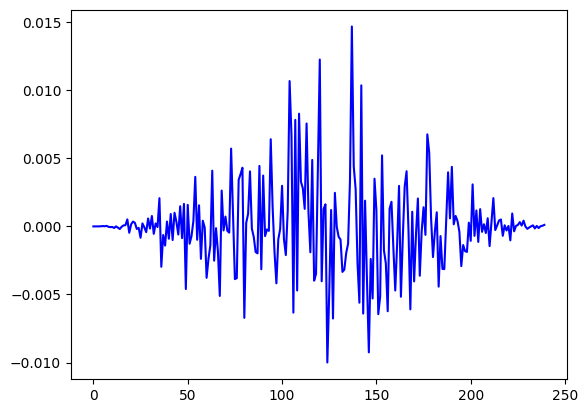

In [9]:
def make_matrix_X(x, p):
    n = len(x)
    # [x_n, ..., x_1, 0, ..., 0]
    xz = np.concatenate([x[::-1], np.zeros(p)])
    
    X = np.zeros((n, p))
    for i in range(n):
        offset = n - i 
        X[i, :] = xz[offset : offset + p]
    return X

def solve_lpc(block, p):
    x = block.T
        
    mX = make_matrix_X(block, p)
    
    a = np.linalg.lstsq(mX, x, rcond=-1)[0]

    e = x - np.dot(mX, a)

    return [a, e]

# Aplicando lpc para un bloque en medio del archivo con una p de 12
[a1, e1] = solve_lpc(blocks[len(blocks)//2], 12)
print(a1)
print(a1.shape)
print(e1.shape)

# El error queda de la siguiente manera
plt.plot(np.array(range(0, len(e1))), e1, 'b')



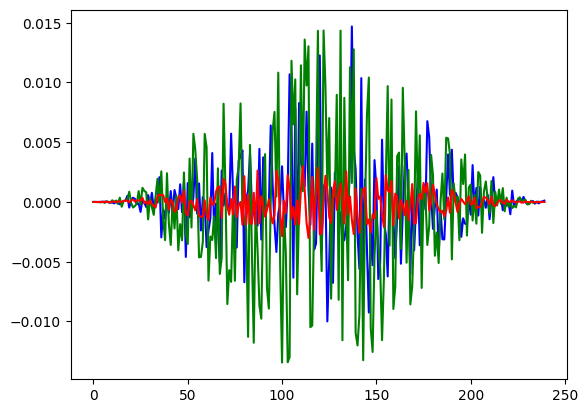

In [10]:
# Como se ve arriba, el error es bastante pequeño y puede ser incluso categorizado como ruido
#    esto nos da la ventaja de ignorarlo. Pero si lo ignoramos, y se necesita reconstruir la señal,
#    se requiere una forma de generar un ruido similar. Esto se puede lograr al utilizar una función
#    de ruido uniforme con la varianza del original, o multiplicandolo por el mayor valor original

# Ninguno es perfecto, y depende de la ventana que se utilice, en este caso el mejor aproximado es
#    el del valor mayor

var = np.var(e1)
noise2 = (np.random.random(windows_samples) * 2 - 1) * max(abs(e1)) * window
noise1 = (np.random.random(windows_samples) * 2 - 1) * np.sqrt(var) * window

plt.plot(np.array(range(0, len(e1))), e1, 'b')
plt.plot(np.array(range(0, len(noise2))), noise2, 'g')
plt.plot(np.array(range(0, len(noise1))), noise1, 'r')

In [11]:
# Con todo esto podemos calcular la LPC de toda la señal, y los coeficientes serían los vectores de
#    caracterísiticas de cada bloque

def lpc_encode(signal, p, window):
    blocks = create_overlapping_blocks(signal, window)
    
    [number_of_blocks, windows_samples] = blocks.shape

    # Los coeficientes se van a calcular por cada bloque
    coefficients = np.zeros((number_of_blocks, p))
    errors = np.zeros((number_of_blocks, windows_samples))

    for i in range(number_of_blocks):
        [a, e] = solve_lpc(blocks[i, :], p)
   
        coefficients[i, :] = a
        errors[i, :] = e
    
    return [coefficients, errors]

p = 12
[coefficients, errors] = lpc_encode(signal, p, window)
print(coefficients.shape)

(790, 12)


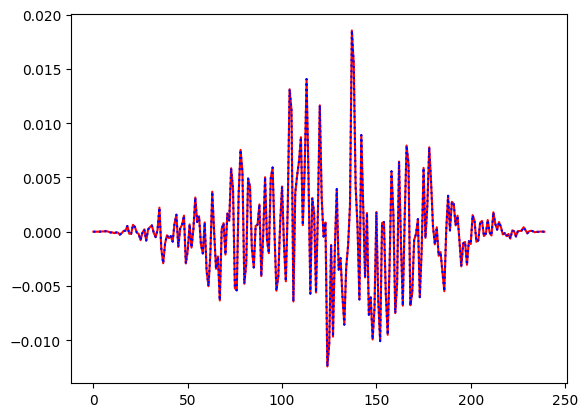

In [12]:
# Incluso, podemos reconstruir la señal original, probemos con el bloque

def lpc_decode_block(a, e):
    a = a[::-1]
    p = len(a)
    n = len(e)
    signal = np.zeros(n + p)
    for i in range(p, n + p):
        signal[i] = np.dot(a, signal[i - p:i]) + e[i - p]
    return signal[p:]

block1 = lpc_decode_block(a1, e1)

plt.plot(np.array(range(windows_samples)), blocks[len(blocks)//2], 'r', label='Señal original')
plt.plot(np.array(range(windows_samples)), block1, 'b:', label='Señal predicha')

(94920,)


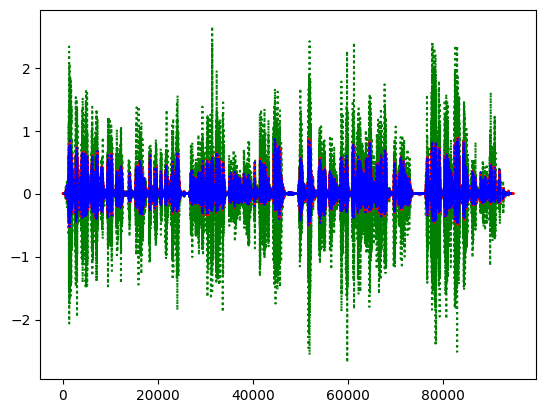

In [13]:
# Ahora se reconsutruirá la señal completa, se reconstruirá de 2 formas distintas:
#   una utilizando el error original
#   una utilizando un error sintético

def lpc_decode(coefficients, errors, window, overlap_ratio):
    num_blocks, _ = coefficients.shape
    window_samples = len(window)
    step = math.floor(window_samples * (1-overlap_ratio))
    
    signal_length = step * (num_blocks - 1) + window_samples
    signal = np.zeros(signal_length)
    
    for i in range(num_blocks):
        a = coefficients[i, :]
        e = errors[i, :]

        block_signal = lpc_decode_block(a, e)

        offset = i * step
        signal[offset:offset + window_samples] += block_signal

    return signal

synthesized_errors = np.zeros_like(errors)
variances = np.zeros(len(errors))
for i in range(len(errors)):
    var = np.var(errors[i])
    variances[i] = var
    synthesized_errors[i, :] = (np.random.random(windows_samples) * 2 - 1) * max(abs(errors[i])) * window

decoded_signal = lpc_decode(coefficients, errors, window, overlap_ratio)
print(decoded_signal.shape)
synthesized_signal = lpc_decode(coefficients, synthesized_errors, window, overlap_ratio)

plt.plot(np.array(range(len(synthesized_signal))), synthesized_signal, 'g:', label='Señal sintetizada')
plt.plot(np.array(range(len(signal))), signal, 'r', label='Señal original')
plt.plot(np.array(range(len(decoded_signal))), decoded_signal, 'b:', label='Señal predicha')

sf.write('audio_decodificado.wav', decoded_signal, sampling_rate)
sf.write('audio_sintetizado.wav', synthesized_signal, sampling_rate)


In [14]:
# La implementación de Librosa se basa en los mismos principios, pero la principal diferencia es
#   que para recuperar la señal original, se necesita pasar por un filtro en vez de aplicar la
#   fórmula calculada (esto se debe a una interpretación diferente de la codificación, comparándola
#   con la forma en que rebotan los sonidos en un tubo, los coeficientes son "parámetros" del 
#   tubo).

# Sin embargo, los coeficientes coinciden bastante bien con los que calculamos con nuestros métodos,
#   sólo que negativos y con un 1 al inicio

def lpc_encode_librosa(signal, p, window):
    blocks = create_overlapping_blocks(signal, window)
    
    [number_of_blocks, windows_samples] = blocks.shape

    # Los coeficientes se van a calcular por cada bloque
    coefficients = np.zeros((number_of_blocks, p + 1))

    for i in range(number_of_blocks):
        a = librosa.lpc(blocks[i, :], order=p)
        coefficients[i, :] = a
    
    return coefficients

coefficients_librosa = lpc_encode_librosa(signal, p, window)
a2 = coefficients_librosa[len(coefficients_librosa)//2, :]

print("Comparación entre librosa y los implementados:")
print(a1)
print(-a2[1:])

Comparación entre librosa y los implementados:
[ 0.62994615 -0.52777798  0.55161253 -0.42562391  0.45233813 -0.42112525
  0.24156509 -0.08424197  0.23935573 -0.25198806 -0.02242388 -0.05189427]
[ 0.62994621 -0.52777785  0.55161206 -0.42562335  0.45233782 -0.42112434
  0.24156441 -0.08424232  0.23935567 -0.25198848 -0.02242329 -0.05189386]


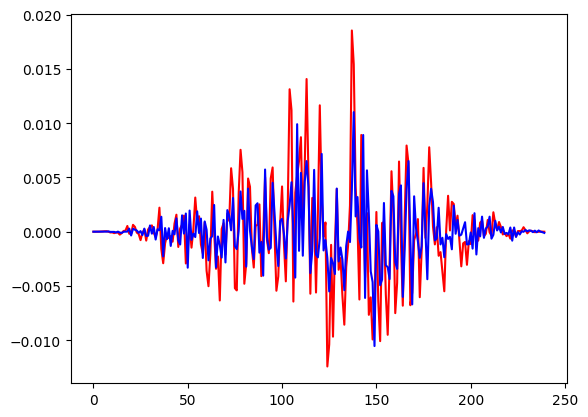

In [15]:
b = np.hstack([[0], -1 * a2[1:]])
block2 = lfilter(b, [1], blocks[len(blocks)//2])

plt.plot(np.array(range(windows_samples)), blocks[len(blocks)//2], 'r', label='Señal original')
plt.plot(np.array(range(windows_samples)), block2, 'b', label='Señal sintetizada')

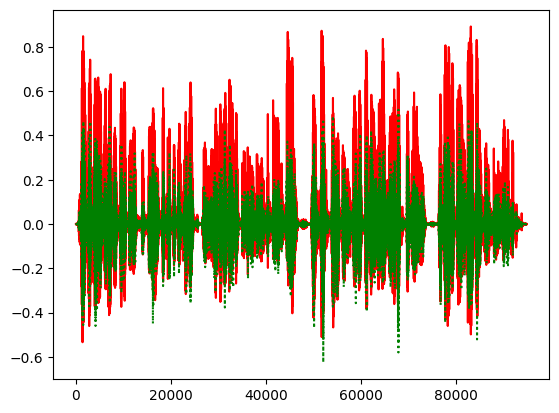

In [16]:
def lpc_decode_librosa(coefficients, variances, window, overlap_ratio):
    num_blocks, _ = coefficients.shape
    window_samples = len(window)
    step = math.floor(window_samples * (1-overlap_ratio))
    
    signal_length = step * (num_blocks - 1) + window_samples
    signal = np.zeros(signal_length)

    errors = np.zeros((num_blocks, windows_samples))

    for i in range(len(errors)):
        var = variances[i]
        errors[i, :] = (np.random.random(windows_samples) * 2 - 1) * np.sqrt(var) * window * 2
    
    for i in range(num_blocks):
        a = coefficients[i, :]
        e = errors[i, :]

        #b = np.hstack([[0], -1 * a[1:]])
        block_signal = lfilter([1], a, e)

        offset = i * step
        signal[offset:offset + window_samples] += block_signal

    return signal

librosa_signal = lpc_decode_librosa(coefficients_librosa, variances, window, overlap_ratio)

plt.plot(np.array(range(len(signal))), signal, 'r', label='Señal original')
plt.plot(np.array(range(len(librosa_signal))), librosa_signal, 'g:', label='Señal sintetizada')

sf.write('audio_librosa.wav', librosa_signal, sampling_rate)